In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Machine Learning
# https://xgboost.readthedocs.io/en/stable/parameter.html
from xgboost import XGBClassifier
#RandomizedSerchCV for finding the best parameters
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

#Reporting
import matplotlib.pyplot as plt


### Import preprocessing Data

In [2]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634


### Add Prediciton Target

In [3]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"]  = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"]  = 0



In [4]:
# Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location 

(array([1945], dtype=int64), array([21], dtype=int64))

In [5]:
### Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-26,-0.002980,-0.010731,-0.038218,29267.224609,0.336031,-0.009984,0.055632,33.189608,38.165993,0.977232,...,3,-0.239867,0.057147,-0.003144,0.026300,0.993166,0.019130,0.034313,1.065192,0.0
2022-05-27,-0.010608,-0.016331,0.002290,28627.574219,-0.005230,-0.021856,0.036020,32.436595,36.240181,0.949541,...,4,-0.291202,0.057119,-0.009984,0.055632,0.977232,-0.003144,0.026300,0.993166,0.0
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,...,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232,0.0
2022-05-29,0.013879,0.023707,0.010035,29445.957031,-0.490594,0.021900,0.022777,33.634047,40.613855,1.090628,...,6,-0.247068,0.055605,0.006544,0.009117,1.027560,-0.021856,0.036020,0.949541,1.0
2022-05-30,0.014593,0.083111,0.016035,31726.390625,1.170788,0.077445,0.090298,36.313300,50.890862,1.253042,...,0,-0.146443,0.057666,0.021900,0.022777,1.090628,0.006544,0.009117,1.027560,0.0


### Train Test Split

In [6]:
# Remove unwanted columns
df_tts = df.copy()

# Dont put future information into the target
df_tts.drop(columns=["Close", "Bench_C_Rets", "Open", "High", "Low"], inplace=True)

In [7]:
# Split
X = df_tts.iloc[:, :-1]
y = df_tts.iloc[:, -1]

In [8]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print("Shape of X_Train:", X_train.shape)


Shape of X_Train: (1556, 16)


### Build initial Model

In [9]:
# Slect type of model to optimise for
is_binary = True
is_optimized_for_precision = True

In [10]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [11]:
# Refine Eval Metric
if is_binary and is_optimized_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimized_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [12]:
# Build First Clasifier Model 0
classifier_0 = XGBClassifier(
    objective = objective, 
    booster = "gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    # use_label_encoder=False
    )

### Find Hyperparameters

In [13]:
# Provide Grids for hyperparams
params_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth" : [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200] # Number of trees we use for xgbooster
}

In [36]:
# Perform Random Serch for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=params_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >> ", f"ne: {ne}, lr: {lr}, md: {md}, gm: {gm}")

Recommended Params >>  ne: 80, lr: 0.05, md: 2, gm: 0.2


### Train model

In [23]:
# Build First Clasifier Model 1
classifier_1 = XGBClassifier(
    objective = objective, 
    booster = "gbtree",
    eval_metric=  eval_metric_list,
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md,
    gamma = gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    # use_label_encoder=False
    )

In [24]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### PerformanceEvaluation (Quick Overview)

In [25]:
# Get Predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 0 0 0 1]


In [26]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [27]:
# Traning Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [30]:
# Breif Review of Training Results
print("Average Accurarcy K-Fold: ", round(train_results.mean(), 2))
print("Std K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 2))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 2))
print("")
print("Just for initial features check. If results are too good to be true, might need to look further.")

Average Accurarcy K-Fold:  0.64
Std K-Fold:  0.06
Precision Score 0:  0.71
Precision Score 1:  0.73

Just for initial features check. If results are too good to be true, might need to look further.


### Feature Selection

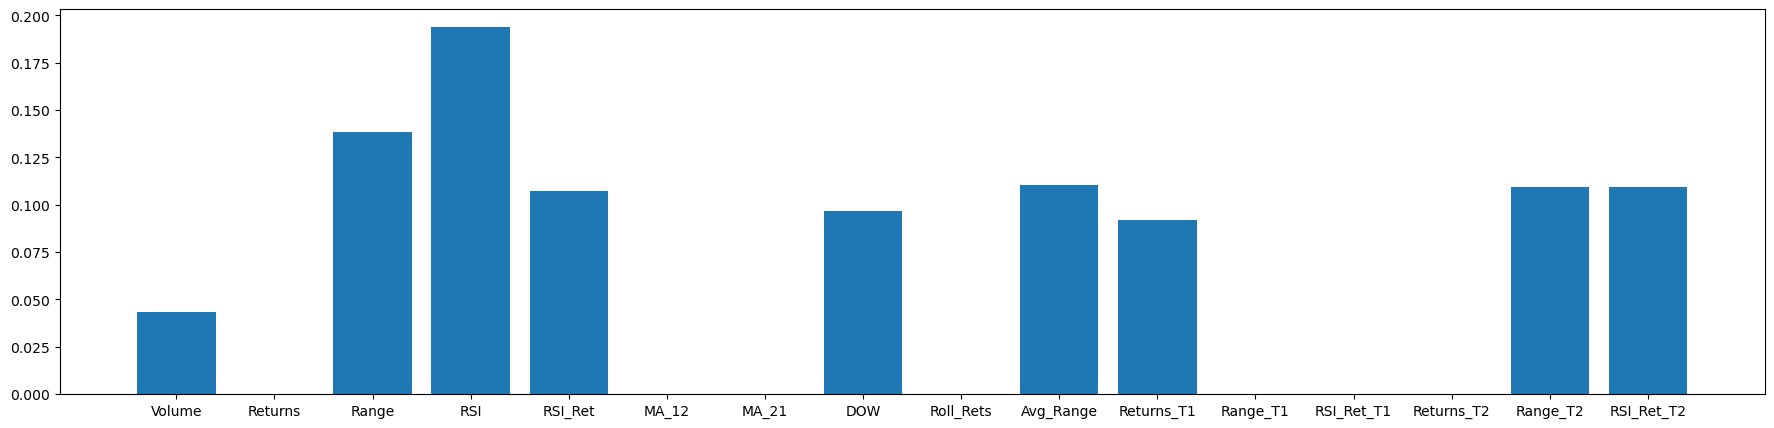

In [31]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [33]:
# Select Bedst Features
mean_feature_importance = importance_features.mean()
recommended_feature_labels = []
recommended_feature_score = []
for i, fi in enumerate(importance_features):
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)

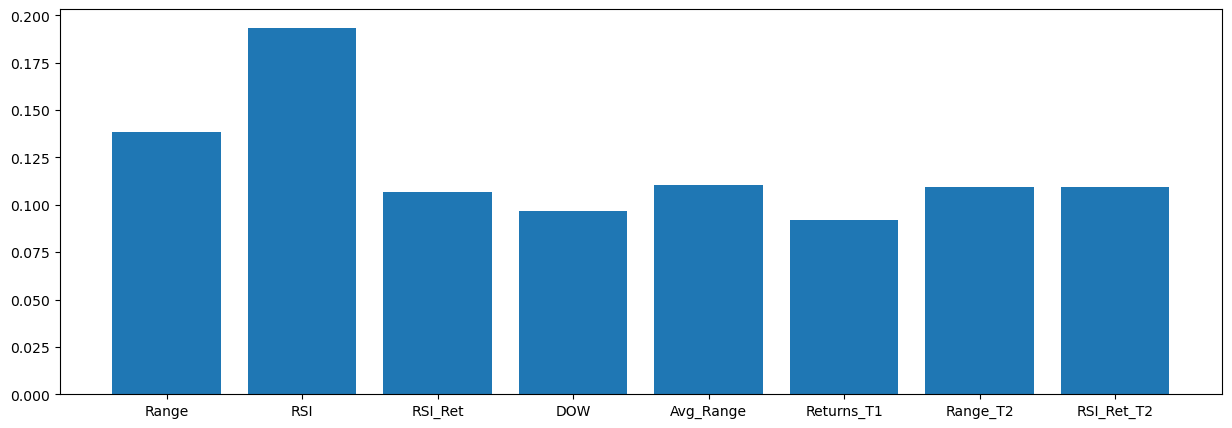

In [34]:
# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()